<a href="https://colab.research.google.com/github/wonseokb/Genat4_Study/blob/main/Deep_Learning_light(HW_Mar26).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/UT-GEOML/GEO391/blob/main/7-DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning

Many of the ideas and techniques in machine learning are old. However, several important breakthroughs happened in the last 10 years or so. One of them was the invention of deep learning with convolutional neural networks in application to visual recognition.

![](https://devopedia.org/images/article/172/1112.1562158549.jpg)

* https://devopedia.org/imagenet

**ImageNet Challenge** was an annual computer vision contest held between 2010 and 2017. The goal was to recognize and label images from a large benchmark dataset.

* Deng, J., Dong, W., Socher, R., Li, L.J., Li, K. and Fei-Fei, L., 2009. [ImageNet: A large-scale hierarchical image database](https://ieeexplore.ieee.org/document/5206848). In 2009 IEEE Conference on Computer Vision and Pattern Recognition (pp. 248-255).

![](https://pbs.twimg.com/media/CYHtC4WVAAEyGAL.png)

* https://www.slideshare.net/NVIDIA/nvidia-ces-2016-press-conference

A breakthrough in accuracy happened in 2012 when a team from the University of Toronto won the contest by applying a deep convolutional neural network. 

* Krizhevsky, A., Sutskever, I. and Hinton, G.E., 2012. [Imagenet classification with deep convolutional neural networks](https://dl.acm.org/doi/10.1145/3065386). Advances in Neural Information Processing Systems, 25, pp.1097-1105.

Today we will discuss the fundamentals of this technique and apply it to the problem of earthquake detection.

## Earthquake detection
We will try reproducing results from the following paper:

* Magrini, F., Jozinović, D., Cammarano, F., Michelini, A. and Boschi, L., 2020. [Local earthquakes detection: A benchmark dataset of 3-component seismograms built on a global scale](https://www.sciencedirect.com/science/article/pii/S2666544120300010). Artificial Intelligence in Geosciences, 1, pp.1-10.

The authors collected a database of seismic recordings from multiple seismic stations around the world. The recording contain records of numerous earthquakes, ranging in magnitude from 0.4 to 7.1.

![](https://ars.els-cdn.com/content/image/1-s2.0-S2666544120300010-gr5.jpg)

![](https://ars.els-cdn.com/content/image/1-s2.0-S2666544120300010-gr4.jpg)

Let us have a look at the data.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Running the code in this notebook requires substantial computational resources - gigabytes of available disk space and preferably a GPU-enabled computer. 

In [Google Colab](https://colab.research.google.com/):
1. Navigate to Edit→Notebook Settings.
2. Select GPU from the Hardware Accelerator drop-down.
</div>

## Loading data

The full dataset is available at https://doi.org/10.5281/zenodo.3648232 

<div class="alert alert-block alert-warning">
<b>Warning:</b> It is a large file (18.4 GB) and takes a long time to download even with a fast network connection.
</div>

```python   
url='https://zenodo.org/record/3648232/files/LEN-DB.hdf5'
```

The data is in HDF-5 format and can be accessed in Python using <code>h5py</code> module.

* https://en.wikipedia.org/wiki/Hierarchical_Data_Format

To avoid memory issues, we will use instead a smaller version that contains about 1/3 of the original data.

A compressed numpy file <code>waveforms.npz</code> is available at https://drive.google.com/file/d/1Wo_kWjCuqzc5k4eTvQOn39nMF5_-HTjX/view?usp=sharing

Using [Google Drive](https://drive.google.com/), you can create a shortcut for a shared file:
1. Right click the file.
2. Click **Add shortcut to Drive**.

In [1]:
# from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

!wget url_to_file # to download a file to the current server that you are running the notebook on

!unzip filename # unzip the zip file (if necessary)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-03-06 23:13:04--  http://url_to_file/
Resolving url_to_file (url_to_file)... failed: Name or service not known.
wget: unable to resolve host address ‘url_to_file’
unzip:  cannot find or open filename, filename.zip or filename.ZIP.


In [2]:
import numpy as np

loaded = np.load('/content/drive/My Drive/waveforms.npz')
#loaded = np.load('/Users/sergey/Downloads/waveforms.npz')
earthquakes = loaded['earthquakes']
noises = loaded['noises']

The dataset is a collection of short three-component waveforms selected from seismic recordings at different stations around the world. Some waveforms correspond to identified earthquakes, others contain noise. 

The goal for a machine learning task is to be able to distinguish earthquakes from noise. 

In [3]:
print('Number of earthquakes:', len(earthquakes))

Number of earthquakes: 100000


In [4]:
print('Number of noise waveforms:', len(noises))

Number of noise waveforms: 100000


In [5]:
import matplotlib.pyplot as plt

time = np.arange(0, 27, 0.05)


def plot_waveform(wf):
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    # Remove space between plots
    fig.subplots_adjust(hspace=0)

    # Plot each component
    for c in range(3):
        ax = axs[c]
        ax.plot(time, wf[:, c])
        ax.set_xlim(0, 27)
        # use scientific notation for y axis
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        ax.set_title(f"{'ZNE'[c]} component", position=(0.5, 0.8), fontsize=20)

    plt.xlabel('Time (s)', fontsize=14)
    plt.show()

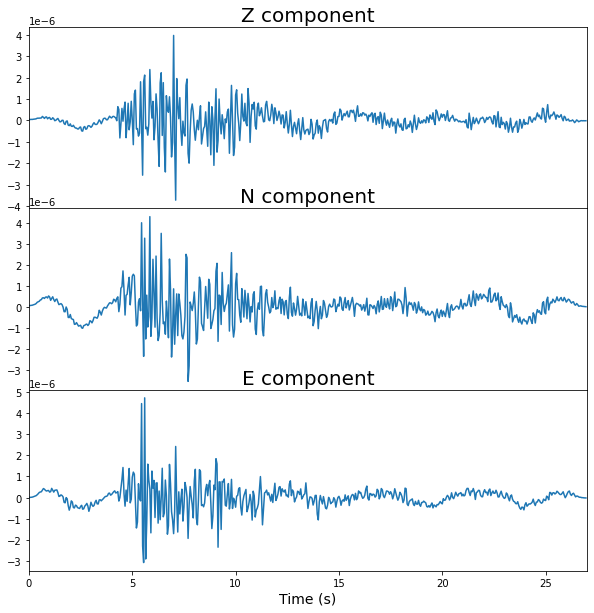

In [6]:
earthquake = earthquakes[1000]
plot_waveform(earthquake)

In [7]:
earthquake.shape

(540, 3)

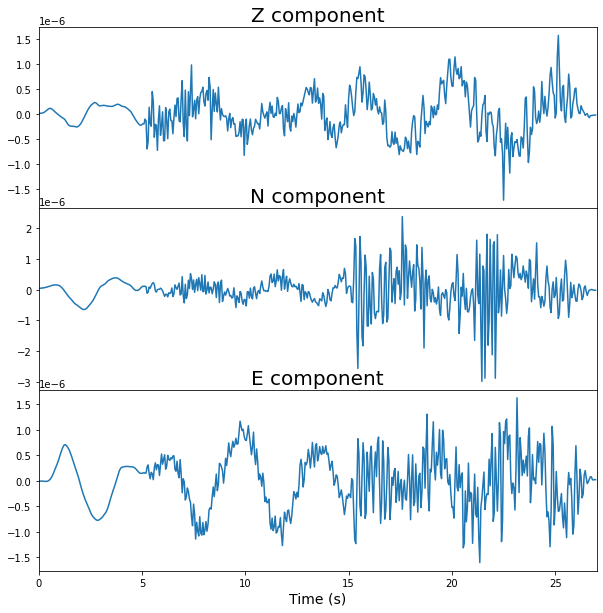

In [8]:
earthquake2 = earthquakes[2000]
plot_waveform(earthquake2)

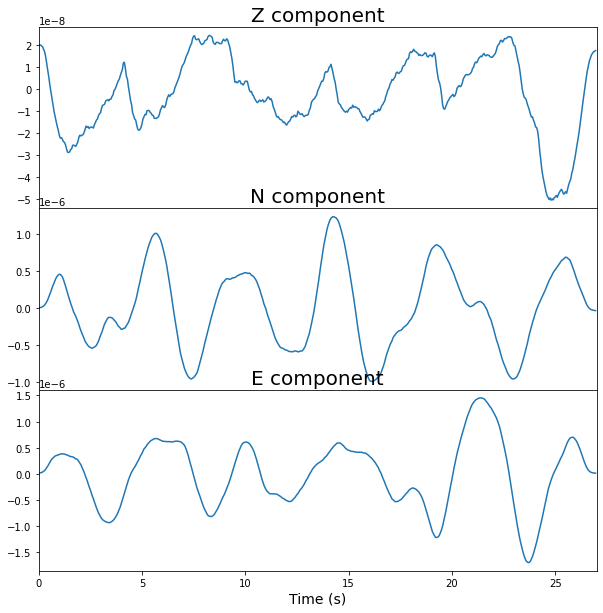

In [9]:
noise = noises[1000]
plot_waveform(noise)

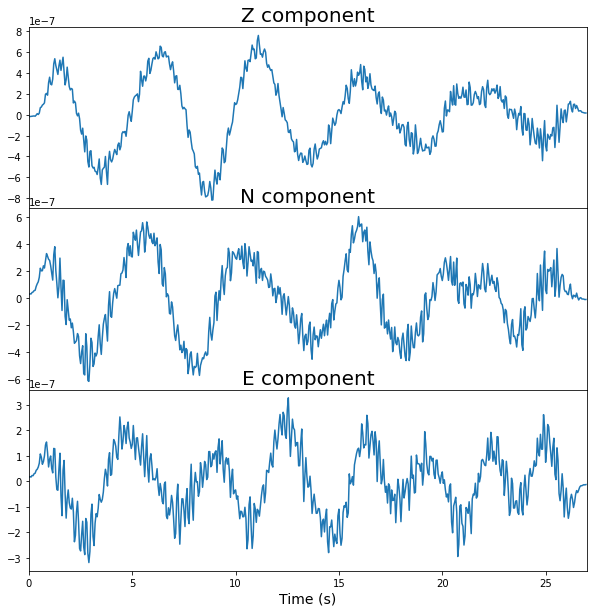

In [10]:
noise2 = noises[2000]
plot_waveform(noise2)

## Use pretrained model

The authors of the paper also provided their own model for waveform classification. 

It was created with Keras and stored in an HDF-5 file.

In [11]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import wget

wget.download('https://github.com/djozinovi/LEN-DB/raw/master/modelFinal.h5')

'modelFinal (1).h5'

In [13]:
from tensorflow import keras

italian_model = keras.models.load_model('modelFinal.h5')

In [14]:
def check_earthquake(model, wf):
    'Check if a waveform contains an earthquake'

    # Reshape from (540,3) to (1,540,3)
    array = np.expand_dims(wf, 0)

    # Add maximum amplitude as extra input
    max_amp = array.max()
    array = array/max_amp

    # Reshape to (1,1)
    max_amp = np.expand_dims(np.array(max_amp), 0)

    pred = model.predict([array, max_amp])
    print('Earthquake probability:', pred[0][0])

In [15]:
check_earthquake(italian_model,earthquake)

1/1 [==============================] - 9s 9s/step
Earthquake probability: 0.99768734


In [16]:
check_earthquake(italian_model,earthquake2)

1/1 [==============================] - 0s 37ms/step
Earthquake probability: 0.9999989


In [17]:
check_earthquake(italian_model,noise)

1/1 [==============================] - 0s 25ms/step
Earthquake probability: 0.011205629


In [18]:
check_earthquake(italian_model,noise2)

1/1 [==============================] - 0s 25ms/step
Earthquake probability: 0.03777201


## Opening the Black Box

Let us see how the model is defined and find layers inside the neural network.

In [19]:
italian_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 wav_input (InputLayer)         [(None, 540, 3)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 540, 32)      320         ['wav_input[0][0]']              
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 542, 32)     0           ['conv1d_1[0][0]']               
 D)                                                                                               
                                                                                                  
 max_pooling1d_1 (MaxPooling1D)  (None, 271, 32)     0           ['zero_padding1d_1[0][0]'] 

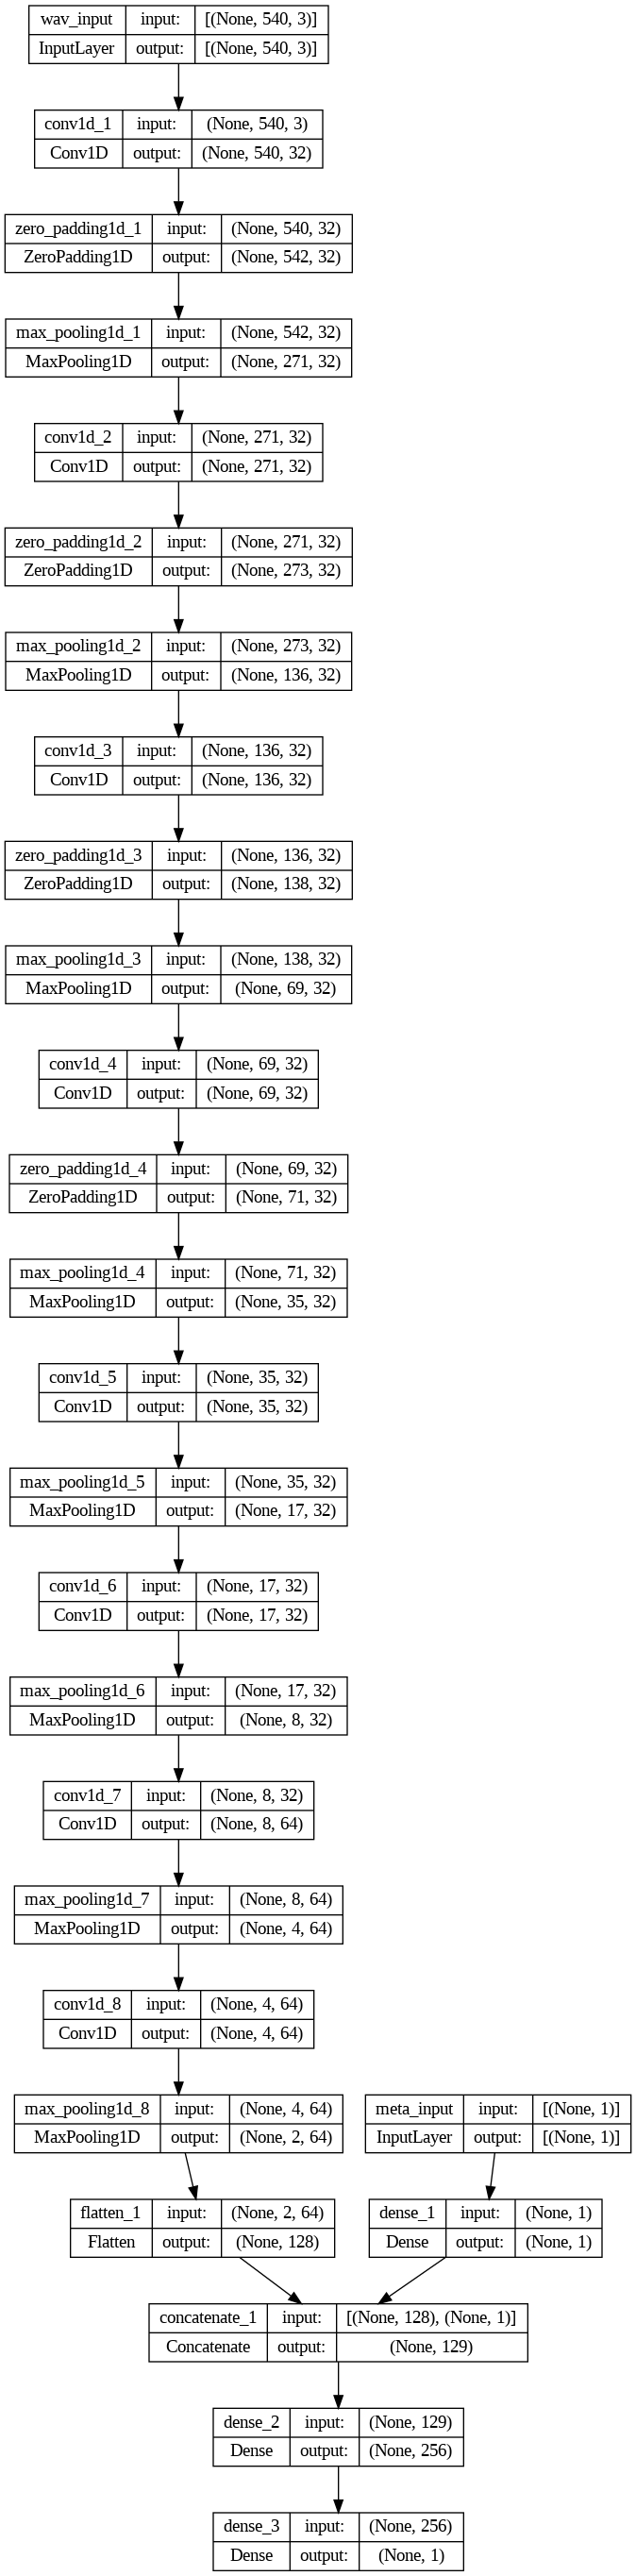

In [20]:
keras.utils.plot_model(italian_model,show_shapes=True)

## Building a Similar Model

Now that we know the model shape, we can try to recreate it.

In [21]:
from tensorflow.keras import layers


def create_model():
    keras.backend.clear_session()

    # the nework will use two inputs
    waveform_input = keras.Input(shape=(540, 3))
    amplitude_input = keras.Input(shape=(1,))

    # first convolutional layer
    x = layers.Conv1D(32, 3, activation='relu')(waveform_input)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    # more layers of similar structure
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Flatten()(x)

    # link second input
    y = layers.Dense(1)(amplitude_input)

    x = layers.Concatenate(axis=1)([x, y])

    x = layers.Dense(256, activation='relu')(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[waveform_input, amplitude_input],
                        outputs=outputs)
    return model


model = create_model()

In [22]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 538, 32)      320         ['input_1[0][0]']                
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 542, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 271, 32)      0           ['zero_padding1d[0][0]']         
                                                                                              

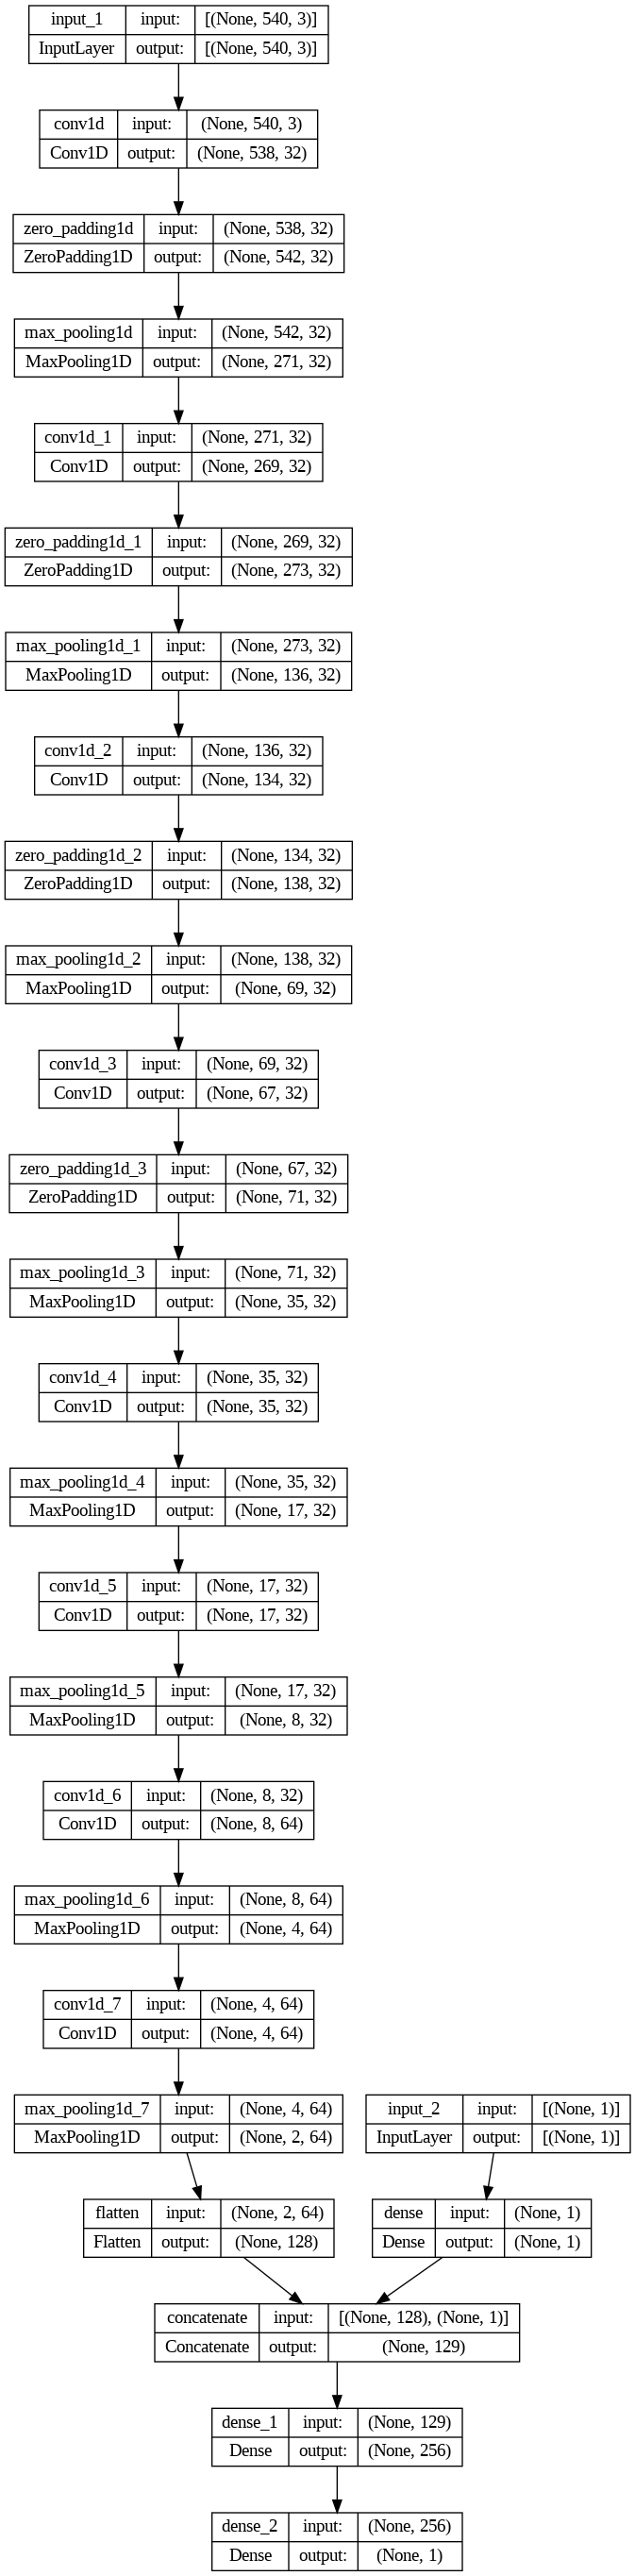

In [23]:
keras.utils.plot_model(model,show_shapes=True)

## What Is Convolution?

Previously we worked with matrix operations inside a neural network (defined by <code>keras.layers.Dense</code>). Such operations are used here at the end of the network. In the output layer, the input has size 256 and the output has size 1. This implies an operation like

$$y_n = s(a_n + \mathbf{b}_n^T\,\mathbf{y}_{n-1})\;,$$

where $s(z)$ is sigmoid, and vector $\mathbf{b}_n$ has the size 256. The total number of parameters in this layer is $256+1=257$.

In the layer before that, the size of the input (vector $\mathbf{y}_{n-2}$) is 129. The operation is

$$\mathbf{y}_{n-1} = r(\mathbf{a}_{n-1} + \mathbf{B}_{n-1}^T\,\mathbf{y}_{n-2})\;,$$

where $r(z)$ is ReLU, vector $\mathbf{a}_{n-1}$ has the size 256, and the matrix $\mathbf{B}_{n-1}$ has the size $129 \times 256$. The total number of parameters is $256 + 129 \times 256 = 33,280$. It is almost half of the total number of parameters in the network.

In [24]:
256+129*256

33280

We can see that the number of parameters grows quickly with the data size. That would make "dense" layers (known as *fully connected* layers) unmanageable for image analysis.

An effective solution is to use *convolution*. A convolution matrix may look like this:
$$\mathbf{C} = \left[\begin{array}{ccccc}
f_1 & 0 & 0 & 0 & 0 \\
f_2 & f_1 & 0 & 0 & 0 \\
f_3 & f_2 & f_1 & 0 & 0 \\
f_4 & f_3 & f_2 & f_1 & 0 \\
0 & f_4 & f_3 & f_2 & f_1 \\
0 & 0 & f_4 & f_3 & f_2 \\
0 & 0 & 0 & f_4 & f_3 \\
0 & 0 & 0 & 0 & f_4
\end{array}\right]$$

It has a special structure, where the filter coefficients ($f_1,f_2,\cdots$) appear on each column with a shift. 

The size of a 1-D convolution matrix is $N \times (N - N_f + 1)$, where $N$ is the size of the input and $N_f$ is the size of the filter. In the example above, $N=8$, $N_f=4$, and the size of the matrix is $8 \times 5$.

The use of convolutions has several advantages:

1. It drastically reduces the number of parameters. 
2. It drastically reduces the cost of the computation, particularly when implemented on graphical processing units (GPUs). The number of operations for a dense matrix multiplication is proportional to the size of the matrix. For convolution, it is proportional to $N \times N_f$, divided by the number of threads for parallel execution on GPU.
3. It exhibits *translation invariance*: the operation remains the same with a shift of the input, which is what we generally expect from visual recognition systems. 

In the first convolutional layer of our network, we use 32 convolutional filters of size $N_f=3$ operating on three input components. This creates 32 outputs of length $N-N_f+1=538$. Mathematically, this can be represented as
$$\mathbf{y}_{1,k} = \displaystyle r\left(\mathbf{a}_{1,k} + \sum_{j=1}^3 \mathbf{C}_{1,jk}^T\,\mathbf{x}_j \right)$$

for $k=1,2,\cdots,32$.

Here $r(z)$ is ReLU, and vectors $\mathbf{a}_{1,k}$ remain constant for consistency with translation invariance.

The number of parameters in this layer is $32 + 3 \times 3 \times 32 = 320$.

If a similar operation was done with a dense (fully connected) layer, the number of parameters would be 

$32 \times 538 + 540 \times 538 \times 3 \times 32 = 27,907,136$. 

In this case, the cost of the operation would be at least $540/3=180$ times higher.

In [25]:
32*538 + 540*538*3*32

27907136

In the second convolutional layer, both the input and the output have 32 channels:

$$\mathbf{y}_{2,k} = \displaystyle r\left(\mathbf{a}_{2,k} + \sum_{j=1}^{32} \mathbf{C}_{2,jk}^T\,\widehat{\mathbf{y}}_{1,j} \right)$$

The number of parameter is $32 + 3 \times 32 \times 32 = 3,104$. 

In [26]:
32 + 3*32*32

3104

In [27]:
layers.Conv1D?

## What Is Max Pooling?

*Max pooling* is similar to convolution in the sense that is using a sliding window over the input data. But instead of computing a weighted sum of inputs, it simply outputs the maximum inside each window. By default, max pooling in <code>keras</code> uses non-overlapping windows of size 2, thus decreasing the size of the input in half.

For example, if the input is a sequence $[9,1,8,6,3,7]$, the output of max pooling would be $[9,8,7]$. By extracting the maxima and by decreasing the size, max pooling focuses the network on learning the most significant patterns in the data and on extracting features useful for classification.

In [28]:
layers.MaxPooling1D?

![](https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg)

* https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

In [29]:
x = np.array([9, 1, 8, 6, 3, 7])
x = np.reshape(x, [1, 6, 1])
max_pool = layers.MaxPooling1D()
max_pool(x)

<tf.Tensor: shape=(1, 3, 1), dtype=int64, numpy=
array([[[9],
        [8],
        [7]]])>

## What Is Zero Padding?

*Zero padding* simply pads the data with zeros to increase its size. By default, 1-D padding will pad the data on both ends. 

For examplem if the input is the sequence $[9,8,7]$, and we pad with 2, the output will be  $[0,0,9,8,7,0,0]$.

Zero padding is often used in combination with convolution and max pooling to control the size of the outputs in hidden layers.

In [30]:
layers.ZeroPadding1D?

In [31]:
x = np.array([9, 8, 7])
x = np.reshape(x, [1, 3, 1])
zero_pad = layers.ZeroPadding1D(2)
zero_pad(x)

<tf.Tensor: shape=(1, 7, 1), dtype=int64, numpy=
array([[[0],
        [0],
        [9],
        [8],
        [7],
        [0],
        [0]]])>

## Network Training and Testing

Now that we understand the components of our DCNN (Deep Convolutional Neural Network), we can proceed to training and testing. 

Let us first prepare the data.

In [32]:
# collect all waveforms
waveforms = np.concatenate((earthquakes, noises))

# extract maximum amplitudes
max_amps = np.amax(np.amax(np.abs(waveforms), axis=2), axis=1)

# normalize by maximum amplitudes
for k in range(max_amps.shape[0]):
    if max_amps[k] > 0:
        waveforms[k, :, :] = waveforms[k, :, :]/max_amps[k]

# add second dimension of 1
max_amps = max_amps.reshape(-1, 1)

print(waveforms.shape, max_amps.shape)

(200000, 540, 3) (200000, 1)


In [33]:
labels = np.array([1]*len(earthquakes)+[0]*len(noises))
labels.shape

(200000,)

In [34]:
from sklearn.model_selection import train_test_split

# Split the data for training and validation
wf_train, wf_valid, am_train, am_valid, eq_train, eq_valid = \
    train_test_split(waveforms, max_amps, labels, test_size=0.3, shuffle=True)

In [35]:
# free some memory
del waveforms
del earthquakes
del noises

In [36]:
eq_valid[:10]

array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1])

In [37]:
model = create_model()
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [38]:
# fit the model
batch_size = 512
epochs = 40

fit = model.fit([wf_train, am_train], eq_train,
                validation_data=([wf_valid, am_valid], eq_valid),
                batch_size=batch_size,
                epochs=epochs)

Epoch 1/40
274/274 [==============================] - 16s 31ms/step - loss: 0.2964 - accuracy: 0.8781 - val_loss: 0.1875 - val_accuracy: 0.9360
Epoch 2/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1612 - accuracy: 0.9445 - val_loss: 0.1496 - val_accuracy: 0.9493
Epoch 3/40
274/274 [==============================] - 6s 21ms/step - loss: 0.1500 - accuracy: 0.9486 - val_loss: 0.1434 - val_accuracy: 0.9520
Epoch 4/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1423 - accuracy: 0.9513 - val_loss: 0.1439 - val_accuracy: 0.9518
Epoch 5/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1372 - accuracy: 0.9528 - val_loss: 0.1432 - val_accuracy: 0.9515
Epoch 6/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1348 - accuracy: 0.9540 - val_loss: 0.1329 - val_accuracy: 0.9562
Epoch 7/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1283 - accuracy: 0.9566 - val_loss: 0.1335 - val_accuracy: 0.954

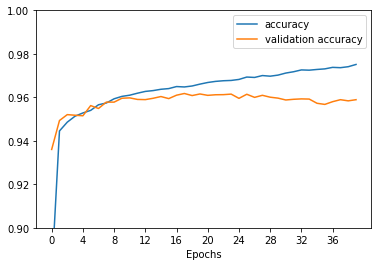

In [39]:
import matplotlib.pyplot as plt


def plot_accuracy(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

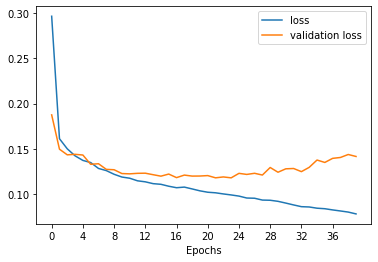

In [40]:
def plot_loss(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

## Checking Results

We can check how well our model works by applying it on example signals and by plotting the confusion matrix.

In [41]:
check_earthquake(model, earthquake) 

1/1 [==============================] - 0s 312ms/step
Earthquake probability: 0.9997731


In [42]:
check_earthquake(model, earthquake2)

1/1 [==============================] - 0s 25ms/step
Earthquake probability: 1.0


In [43]:
check_earthquake(model, noise)

1/1 [==============================] - 0s 24ms/step
Earthquake probability: 0.001866703


In [44]:
check_earthquake(model, noise2)

1/1 [==============================] - 0s 23ms/step
Earthquake probability: 0.031713404


1875/1875 [==============================] - 7s 4ms/step


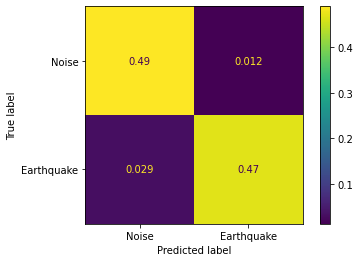

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay

eq_pred = model.predict([wf_valid, am_valid])
cm = ConfusionMatrixDisplay.from_predictions(eq_valid, np.rint(eq_pred),
                                             normalize='all',
                                             display_labels=['Noise', 'Earthquake'])

## <span style="color:red">Task 1</span>

For comparison, display the confusion matrix for the "Italian" model provided by Magrini et al. (2020). 

1875/1875 [==============================] - 7s 3ms/step


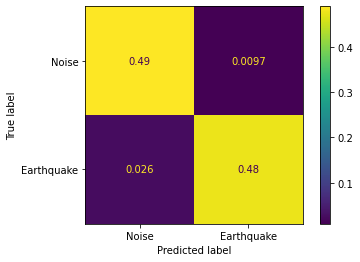

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay

eq_pred = italian_model.predict([wf_valid, am_valid])
cm = ConfusionMatrixDisplay.from_predictions(eq_valid, np.rint(eq_pred),
                                             normalize='all',
                                             display_labels=['Noise', 'Earthquake'])

## <span style="color:red">Task 2</span>

The behavior of the accuracy and loss curves above show a clear case of *overfitting*. Between training and validation, the curves behave similarly at early epochs but later start to diverge. Training becomes more accurate at the expense of tuning to training data while missing general patterns exhibited in validation data. 

There are several known remedies for the overfitting problem:

1. Stop early.

One of the simplest methods is to stop the fitting process before traing and validation start to diverge.

To test it, create a new model similar to the previous one but train it for a smaller number of epochs. Check if the accuracy of the new model is improved.

In [47]:
model_task2 = create_model()
model_task2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
# fit the model
batch_size = 512
epochs = 12

fit = model_task2.fit([wf_train, am_train], eq_train,
                validation_data=([wf_valid, am_valid], eq_valid),
                batch_size=batch_size,
                epochs=epochs)

Epoch 1/12
274/274 [==============================] - 11s 27ms/step - loss: 0.2540 - accuracy: 0.9072 - val_loss: 0.1804 - val_accuracy: 0.9400
Epoch 2/12
274/274 [==============================] - 6s 22ms/step - loss: 0.1567 - accuracy: 0.9465 - val_loss: 0.1534 - val_accuracy: 0.9496
Epoch 3/12
274/274 [==============================] - 6s 22ms/step - loss: 0.1454 - accuracy: 0.9503 - val_loss: 0.1498 - val_accuracy: 0.9514
Epoch 4/12
274/274 [==============================] - 7s 24ms/step - loss: 0.1376 - accuracy: 0.9535 - val_loss: 0.1340 - val_accuracy: 0.9546
Epoch 5/12
274/274 [==============================] - 7s 24ms/step - loss: 0.1324 - accuracy: 0.9554 - val_loss: 0.1283 - val_accuracy: 0.9568
Epoch 6/12
274/274 [==============================] - 6s 22ms/step - loss: 0.1293 - accuracy: 0.9565 - val_loss: 0.1263 - val_accuracy: 0.9570
Epoch 7/12
274/274 [==============================] - 6s 22ms/step - loss: 0.1254 - accuracy: 0.9581 - val_loss: 0.1232 - val_accuracy: 0.958

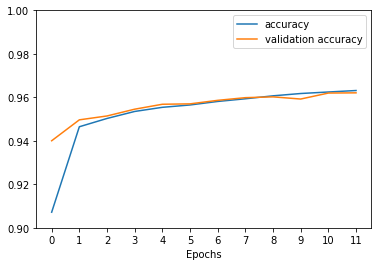

In [49]:
import matplotlib.pyplot as plt


def plot_accuracy(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

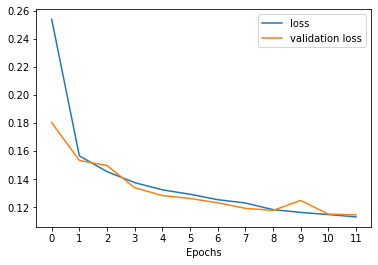

In [50]:
def plot_loss(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

2. Use *dropout*.

As we saw previously, another approach to overfitting is the dropout method.

To test it, modify the model to add a dropout layer. One logical place for this layer will be after a fully connected <code>Dense</code> layer with a large number of parameters.

In [51]:
drop = 0.9  # drop out 10% of neurons

def create_model_task2_2():
    keras.backend.clear_session()

    # the nework will use two inputs
    waveform_input = keras.Input(shape=(540, 3))
    amplitude_input = keras.Input(shape=(1,))

    # first convolutional layer
    x = layers.Conv1D(32, 3, activation='relu')(waveform_input)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    keras.layers.Dropout(drop)#######

    # more layers of similar structure
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Flatten()(x)

    # link second input
    y = layers.Dense(1)(amplitude_input)

    x = layers.Concatenate(axis=1)([x, y])

    x = layers.Dense(256, activation='relu')(x)
    

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[waveform_input, amplitude_input],
                        outputs=outputs)
    return model

In [52]:
model_task2_3 = create_model_task2_2()
model_task2_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [53]:
# fit the model
batch_size = 512
epochs = 40

fit = model_task2_3.fit([wf_train, am_train], eq_train,
                validation_data=([wf_valid, am_valid], eq_valid),
                batch_size=batch_size,
                epochs=epochs)

Epoch 1/40
274/274 [==============================] - 14s 26ms/step - loss: 0.2648 - accuracy: 0.8941 - val_loss: 0.1636 - val_accuracy: 0.9440
Epoch 2/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1596 - accuracy: 0.9455 - val_loss: 0.1466 - val_accuracy: 0.9493
Epoch 3/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1470 - accuracy: 0.9492 - val_loss: 0.1421 - val_accuracy: 0.9507
Epoch 4/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1408 - accuracy: 0.9521 - val_loss: 0.1369 - val_accuracy: 0.9520
Epoch 5/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1362 - accuracy: 0.9537 - val_loss: 0.1325 - val_accuracy: 0.9546
Epoch 6/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1306 - accuracy: 0.9560 - val_loss: 0.1302 - val_accuracy: 0.9563
Epoch 7/40
274/274 [==============================] - 6s 22ms/step - loss: 0.1277 - accuracy: 0.9573 - val_loss: 0.1339 - val_accuracy: 0.954

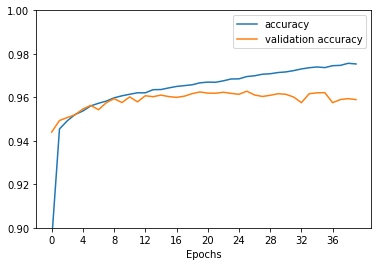

In [54]:
import matplotlib.pyplot as plt


def plot_accuracy(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['accuracy'], label='accuracy')
    plt.plot(iterations, fit.history['val_accuracy'],
             label='validation accuracy')
    plt.legend()
    plt.ylim(0.9, 1.0)
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_accuracy(fit, epochs)

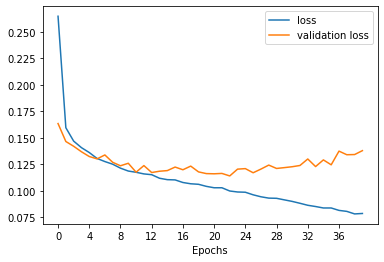

In [55]:
def plot_loss(fit, epochs):
    iterations = np.arange(epochs)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

<span style="color:blue">[**EXTRA CREDIT**]</span> 3. Simplify the network.

We can also reduce the number of parameters by decreasing the number of hidden layers or the dimensions of intermediate outputs (features). 

In [55]:
#drop = 0.9  # drop out 10% of neurons

def create_model_task2_extra():
    keras.backend.clear_session()

    # the nework will use two inputs
    waveform_input = keras.Input(shape=(540, 3))
    amplitude_input = keras.Input(shape=(1,))

    # first convolutional layer
    x = layers.Conv1D(32, 3, activation='relu')(waveform_input)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    #keras.layers.Dropout(drop)#######

    # more layers of similar structure
    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    #keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    #keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, activation='relu')(x)
    x = layers.ZeroPadding1D(2)(x)
    x = layers.MaxPooling1D()(x)

    #keras.layers.Dropout(drop)#######

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(32, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)

    x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
    x = layers.MaxPooling1D()(x)
    x = layers.Flatten()(x)

    # link second input
    y = layers.Dense(1)(amplitude_input)

    #x = layers.Concatenate(axis=1)([x, y])

    x = layers.Dense(256, activation='relu')(x)
    

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[waveform_input, amplitude_input],
                        outputs=outputs)
    return model

In [56]:
model_task2_extra = create_model_task2_extra()
model_task2_extra.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [57]:
model_task2_extra.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 3)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 538, 32)      320         ['input_1[0][0]']                
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 542, 32)     0           ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 271, 32)      0           ['zero_padding1d[0][0]']         
                                                                                              

###The Total params reduces from 67,939 to 67,681

## <span style="color:red">Task 3</span>

Find an example earthquake waveform that your network wrongly classifies as noise and display it using <code>plot_waveform</code>. 

1875/1875 [==============================] - 7s 4ms/step


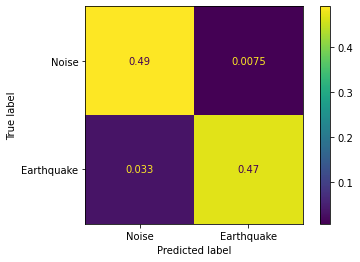

In [61]:
eq_pred = model.predict([wf_valid, am_valid])
cm = ConfusionMatrixDisplay.from_predictions(eq_valid, np.rint(eq_pred),
                                             normalize='all',
                                             display_labels=['Noise', 'Earthquake'])

In [71]:
print(np.rint(eq_pred))

[[1.]
 [0.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]


In [72]:
np.rint(eq_pred).shape

(60000, 1)

In [63]:
eq_valid

array([1, 1, 1, ..., 0, 0, 1])

In [70]:
eq_valid.shape

(60000,)

In [73]:
misclassified_indices = np.where(eq_valid != np.ravel(np.rint(eq_pred)))[0]

In [74]:
print("Misclassified indices:", misclassified_indices)

Misclassified indices: [    1    67    84 ... 59944 59969 59976]


In [75]:
misclassified_indices.shape

(2403,)

###There are 2403 misclassified waves. let me show the first 3

In [76]:
wf_valid.shape

(60000, 540, 3)

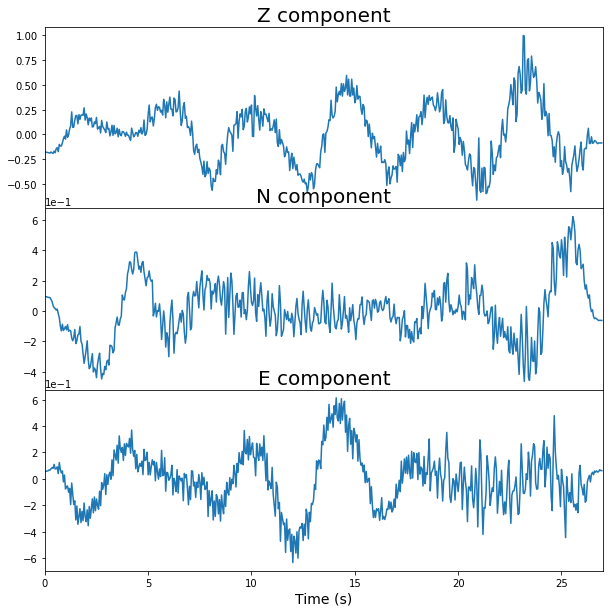

In [78]:
wf_valid_task3 = wf_valid[1]
plot_waveform(wf_valid_task3)

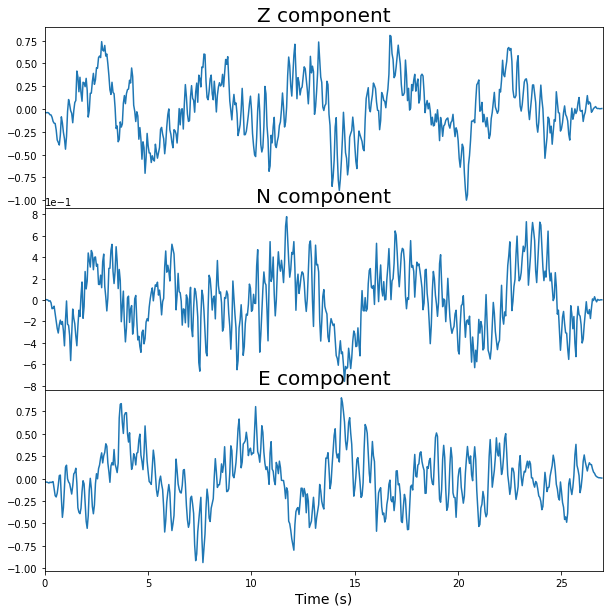

In [79]:
wf_valid_task3 = wf_valid[67]
plot_waveform(wf_valid_task3)

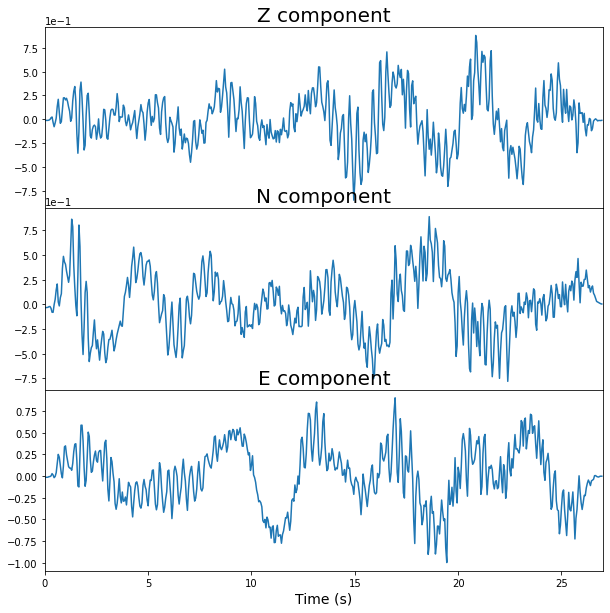

In [80]:
wf_valid_task3 = wf_valid[84]
plot_waveform(wf_valid_task3)